In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

import cv2
import os
import pandas as pd
from collections import Counter as cnt
import matplotlib.pyplot as plt
import torch
import sys

sys.path.append('/home/bis/230711_JSG/230602_JSG_Image/')
#import module
from Mymodule.ModelHandler import *
from Mymodule.Utils import *
from Mymodule.GradCam import *
from Mymodule.BatchHandler import *
from collections import Counter as cnt
from torchvision import transforms
from keras import Sequential
from torch import nn
from torchvision import models

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score, confusion_matrix

from torch import optim

In [6]:
class LayerActivation():
    features = None    
    def __init__(self, model, layer_num):
        self.hook = model.base.features[layer_num].register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output):
        self.features = output.cpu().data.numpy()
    def remove(self):
        self.hook.remove()

        
activation = {}

def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

def calculate_zero_ratios(img):
    w, h = img.shape
    zeros = 0
    for i in range(w):
        for j in range(w):
            if img[i, j] <= 0:
                zeros += 1
    return zeros / (w*h)

In [8]:
#candidates = ['10749325(2)_56_0', '10859932(2)_78_0', '10749325(3)_56_1']
candidates  = ['14934497_23_1', '14985233_40_1', '14943382_51_1']
candidates2 = ['14934497 23 2', '14985233 40 2', '14943382 51 2']
root = './Data/cropped_images/'

images = {}
image_names = {}
crops = [1, 3,4,6]
for crop in crops:
    images[crop] = []
    image_names[crop] = []
    for i,candidate in enumerate(candidates):
        if crop == 1 :
            image_path = f'''./Images/Validation/{candidates2[i]}.png'''
            image = cv2.imread(image_path)
            image = cv2.resize(image,(140,140))
            images[crop].append(image)
            image_names[crop].append(image_path)
                
        else: 
            image_root = os.path.join(root,'crop'+f'_{crop}', 'val', candidate)
            surfixs = []
            for i in range(crop): surfixs.append(f'_part_{i+1}.png')
            for surfix in surfixs:
                image_path = image_root + surfix
                image = cv2.imread(image_path)
                image = cv2.resize(image,(140,140))
                images[crop].append(image)
                image_names[crop].append(image_path)
    images[crop] = np.array(images[crop])
    test_y = np.zeros([9,1])

/home/bis/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/bis/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


0.7766
0.7798
0.7823
0.7762
0.7792
0.7871
0.7828
0.7783
0.7882
0.7762
0.7793
0.7773
0.7852
0.7775
0.7849
0.7861
0.7837
0.7825
0.7778
0.7829


/tmp/ipykernel_2393600/1716581375.py:22: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(13,4))


0.7834
0.7818
0.7780
0.7754
0.7847
0.7883
0.7757
0.7773
0.7861
0.7918
0.7815
0.7757
0.7810
0.7841
0.7735
0.7853
0.7692
0.7756
0.7765
0.7819
0.7756
0.7736


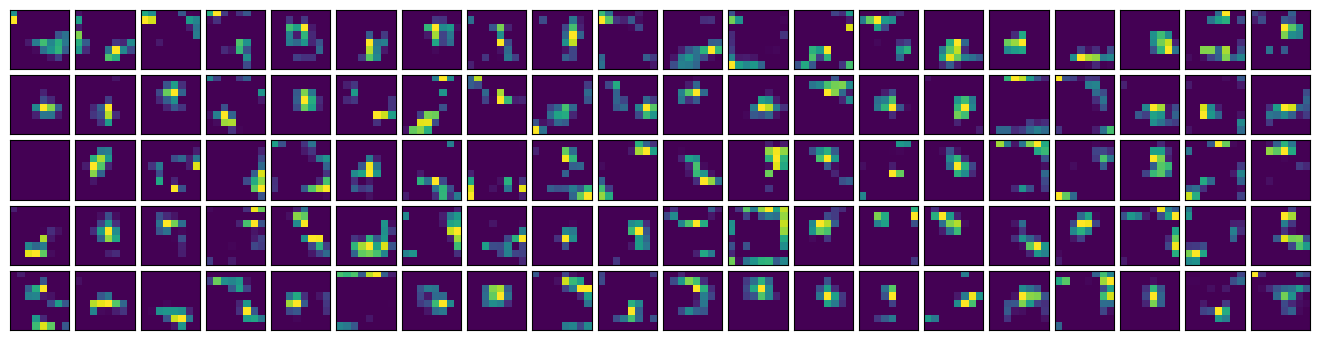

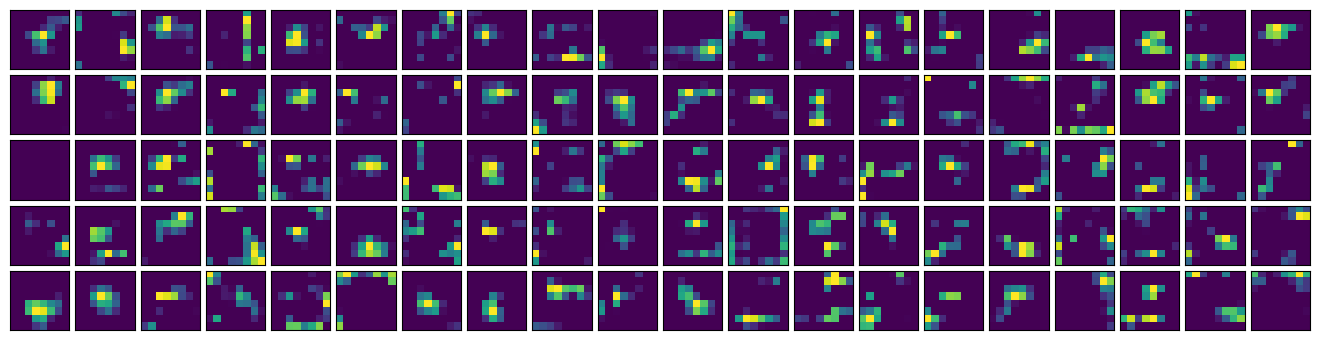

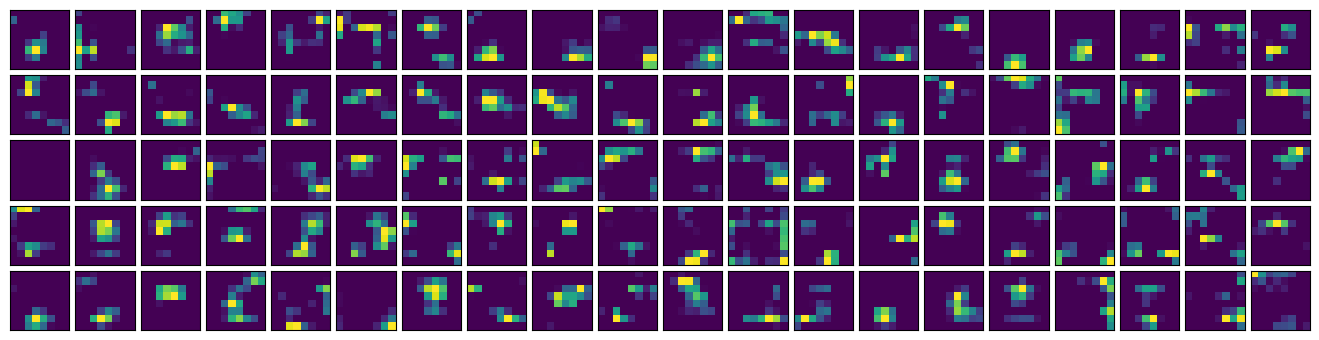

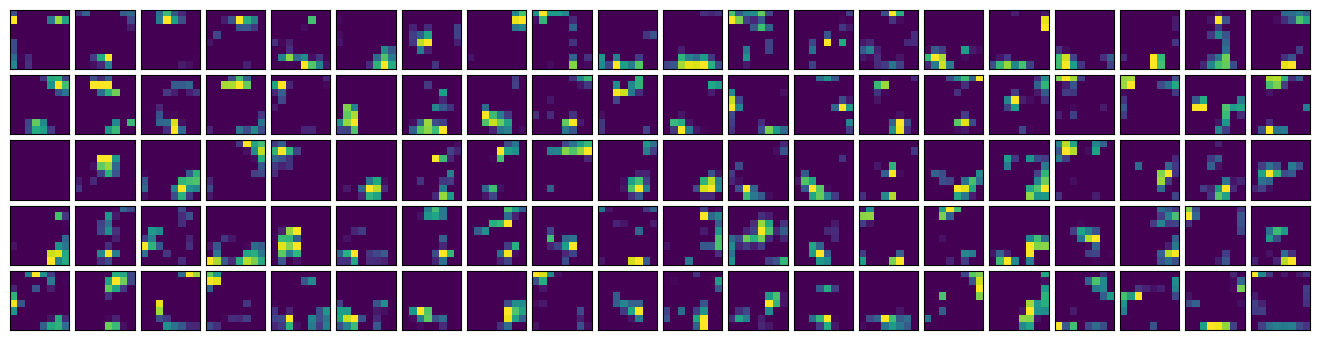

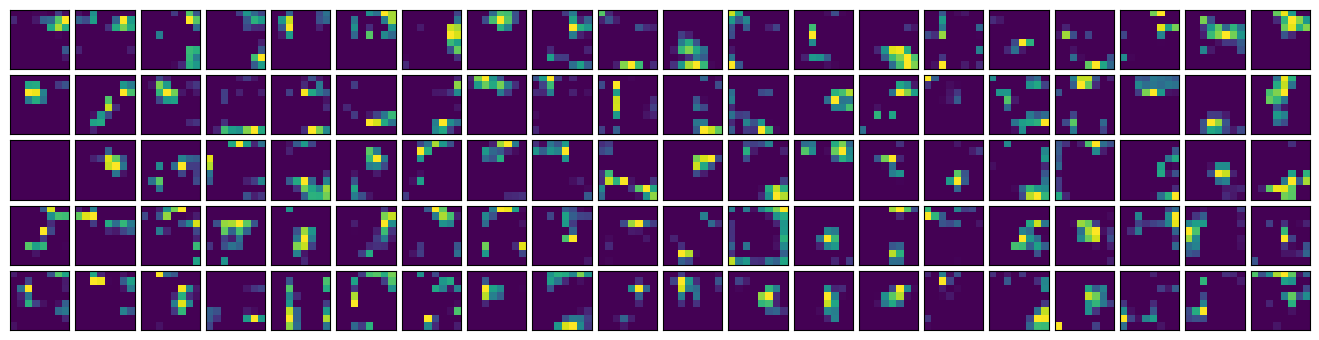

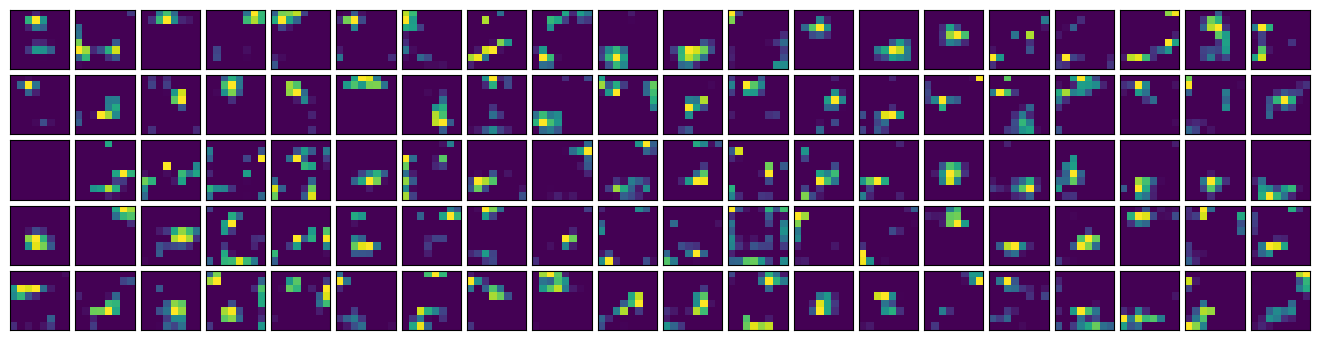

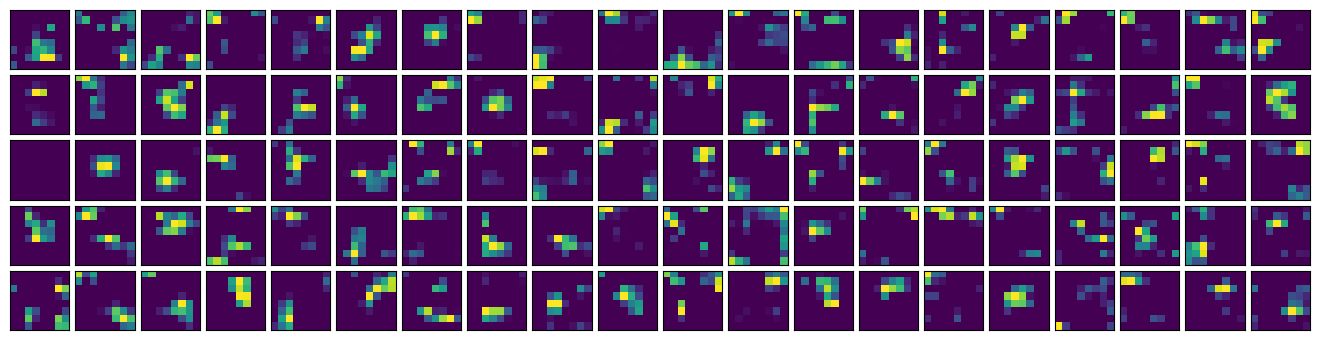

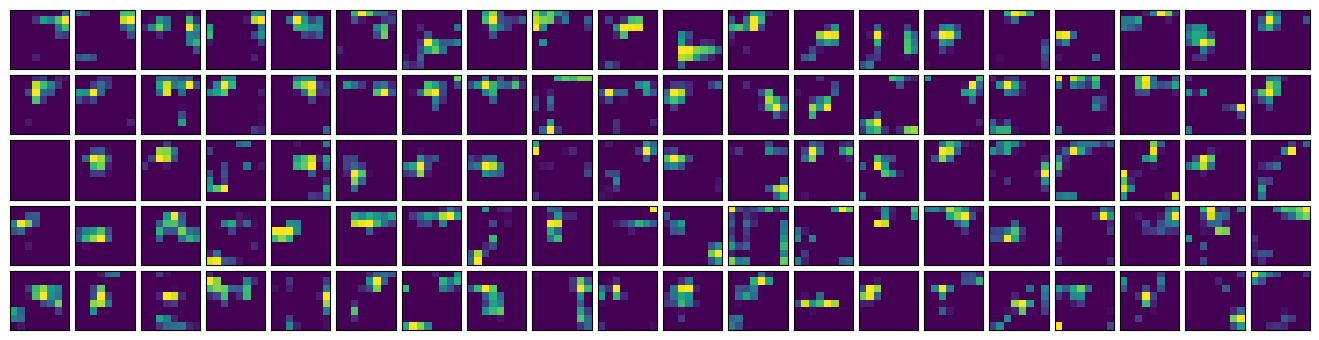

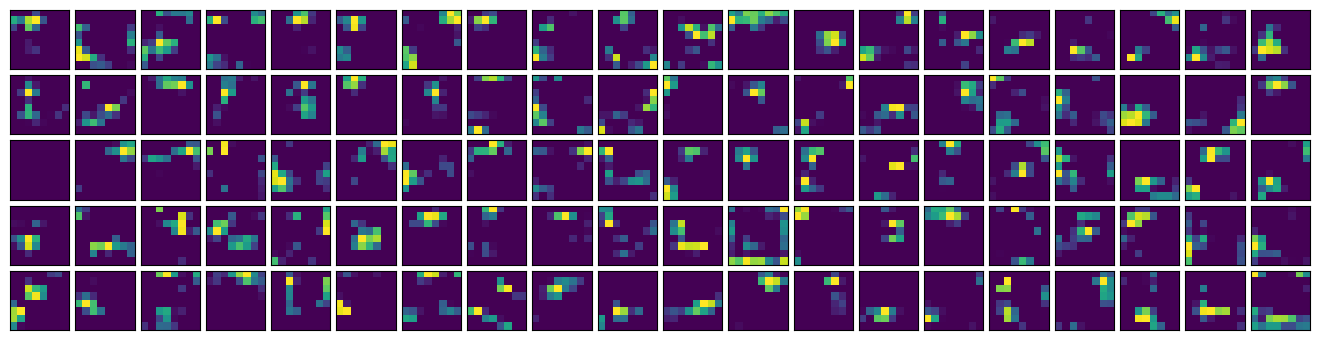

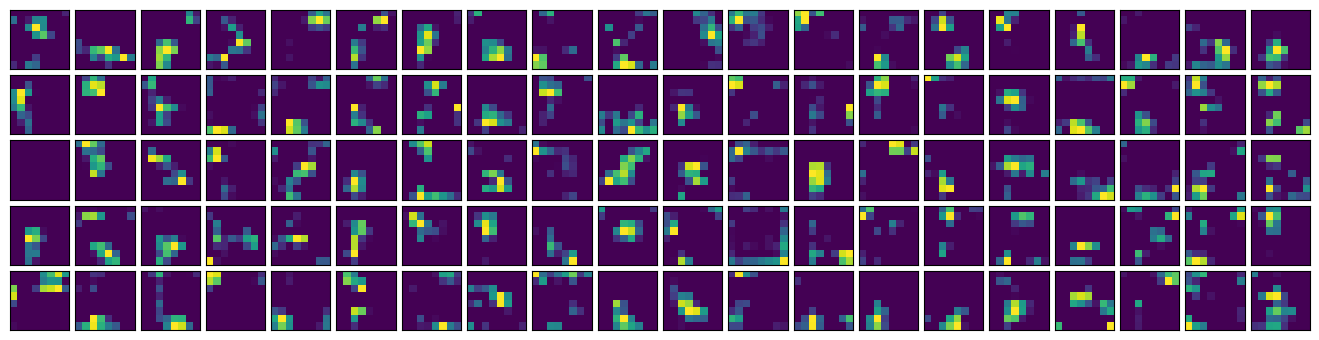

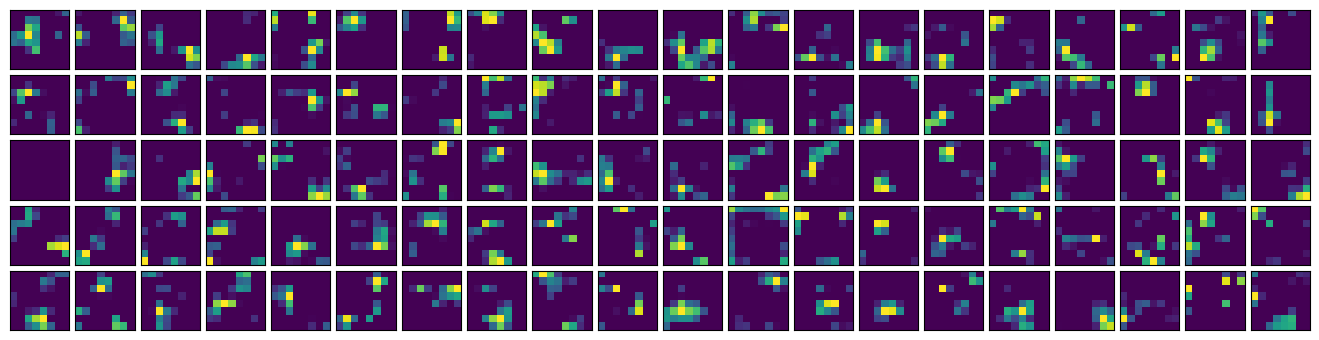

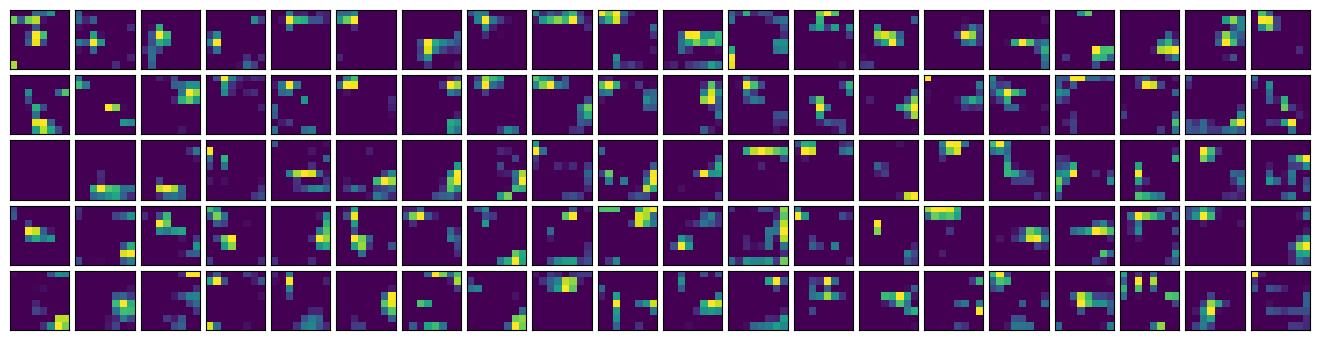

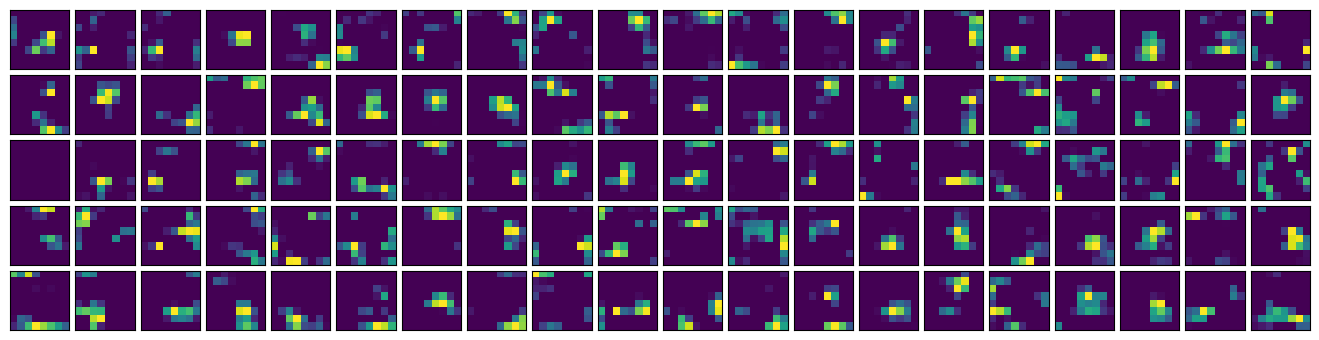

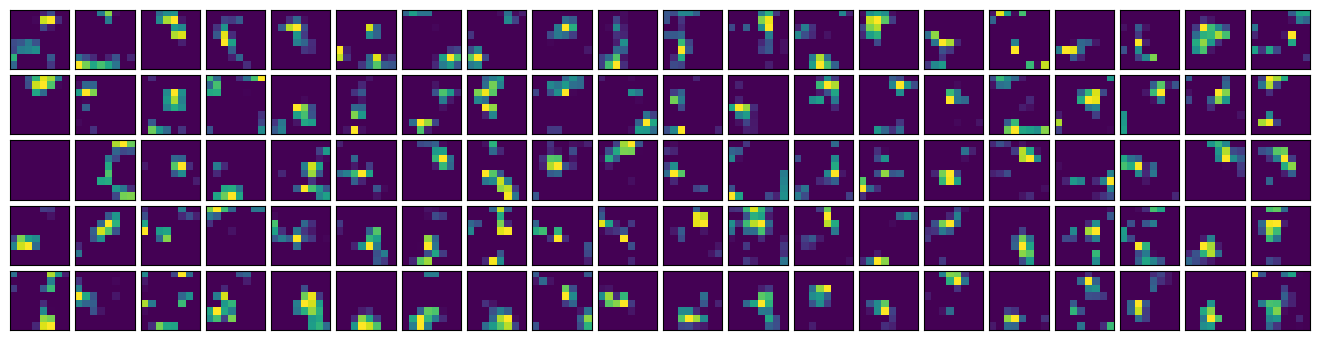

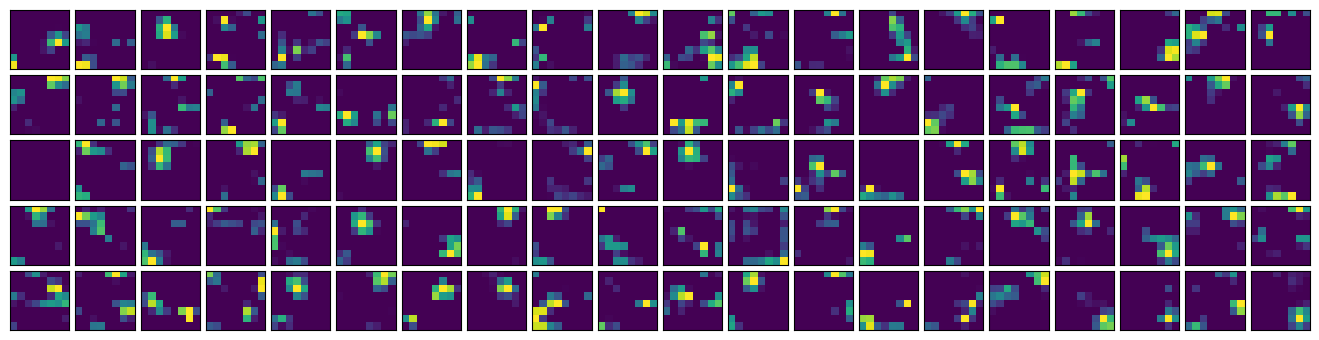

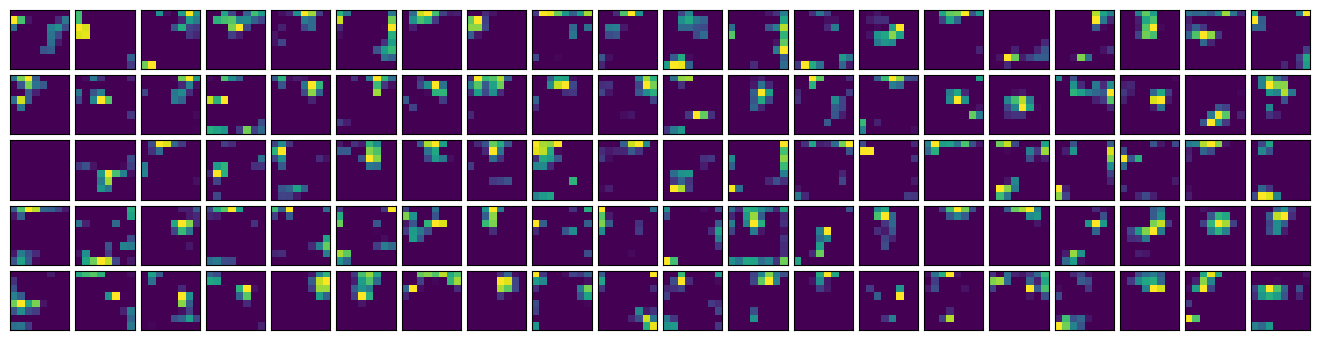

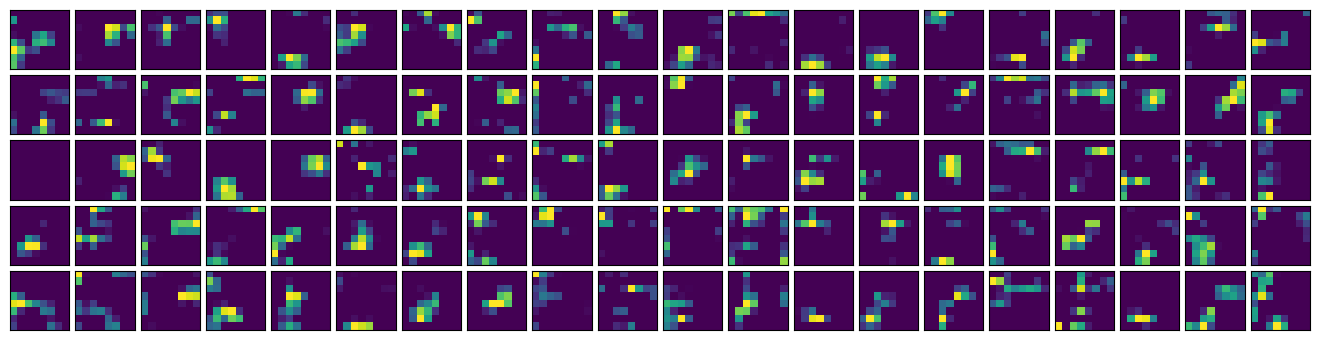

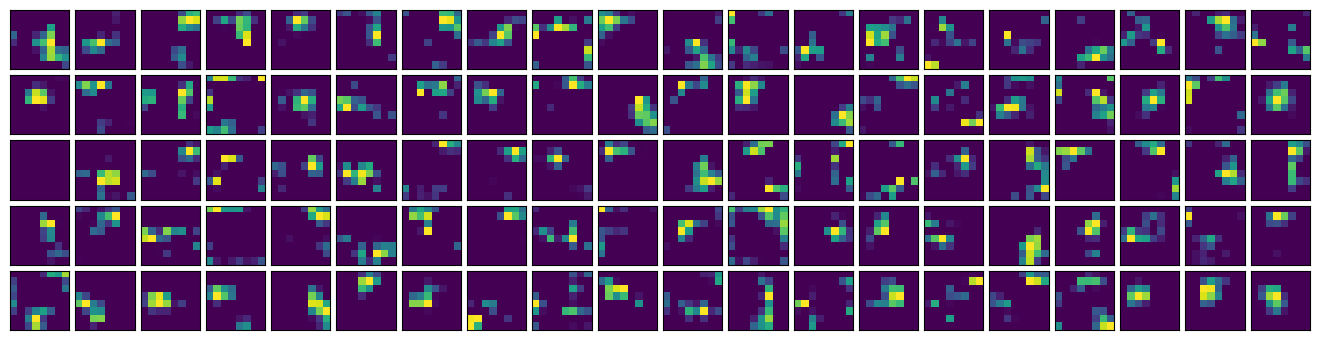

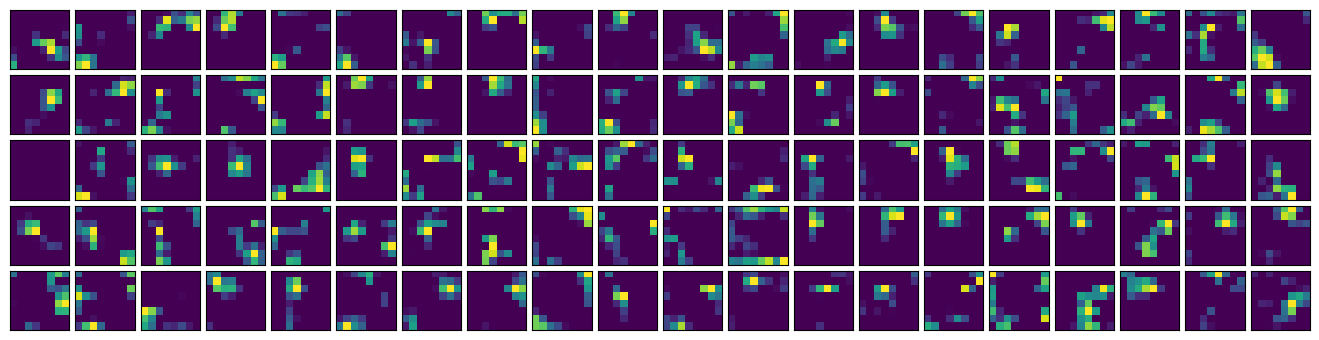

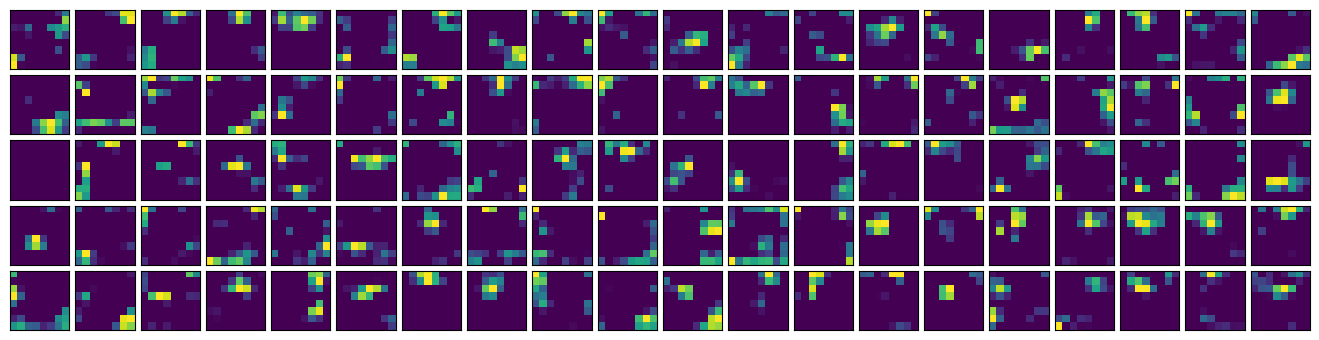

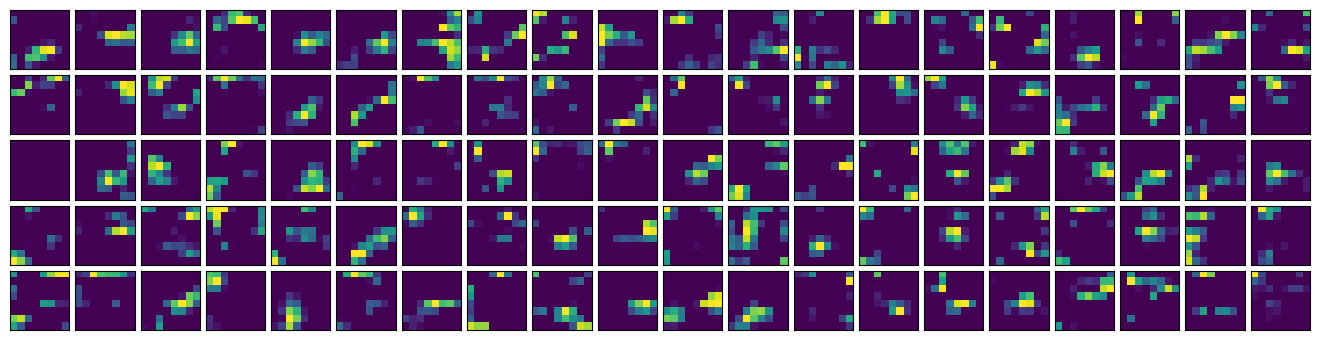

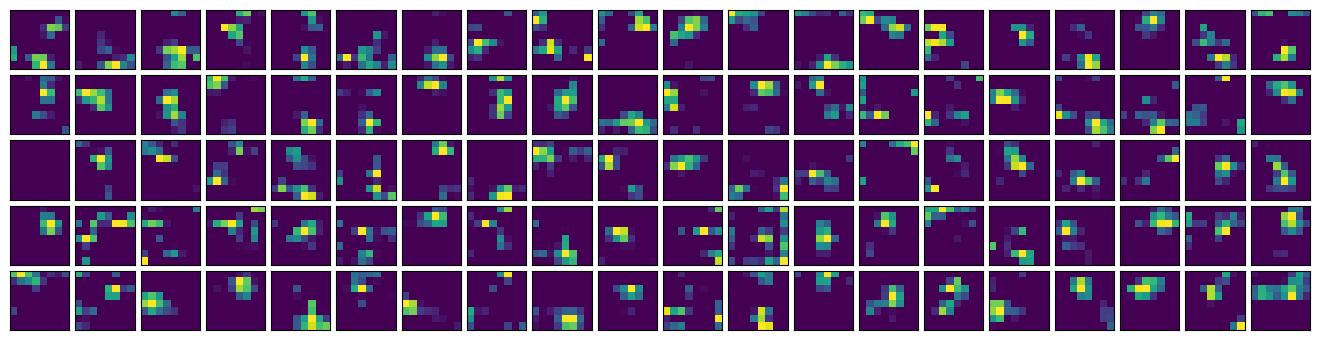

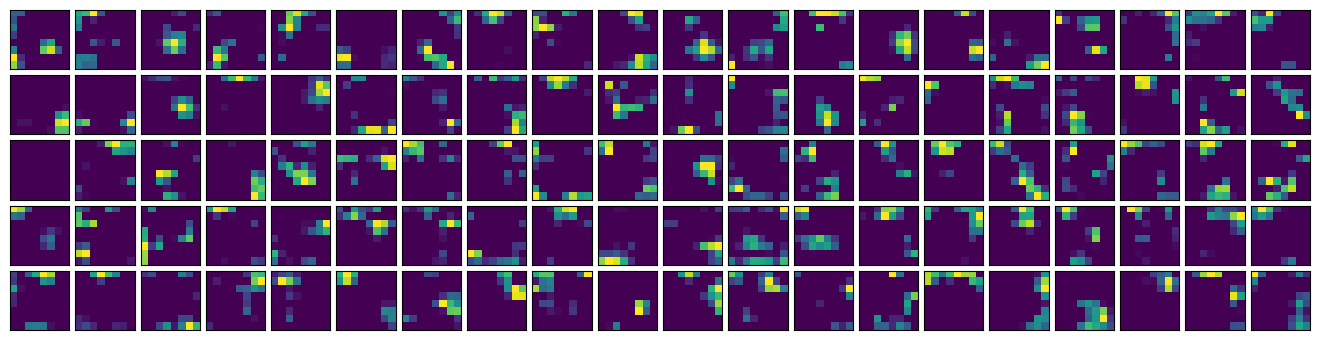

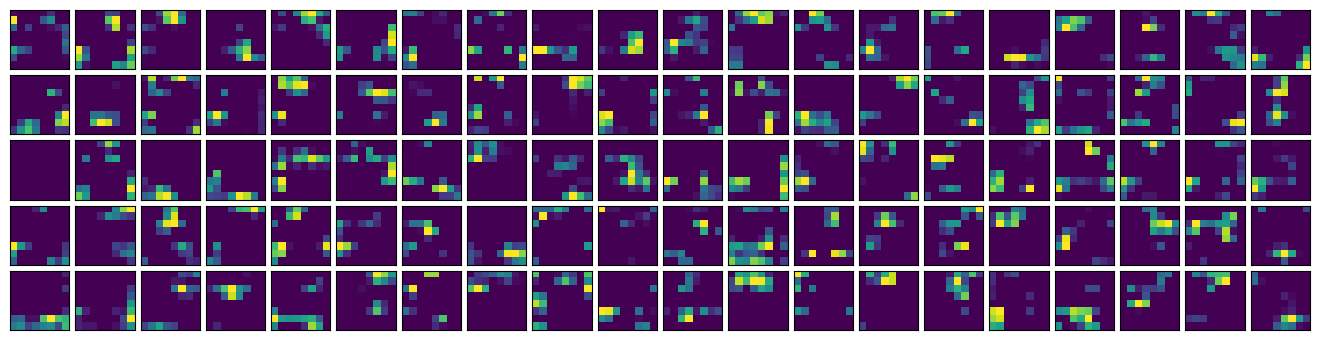

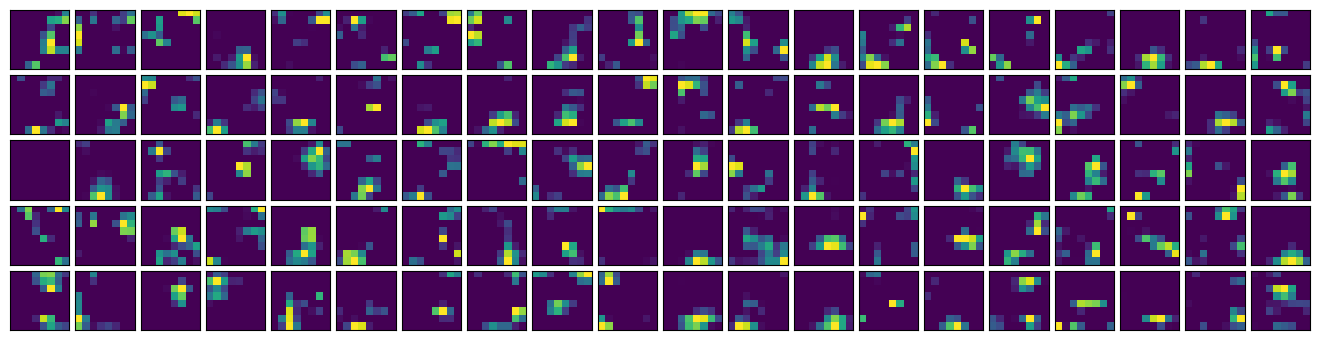

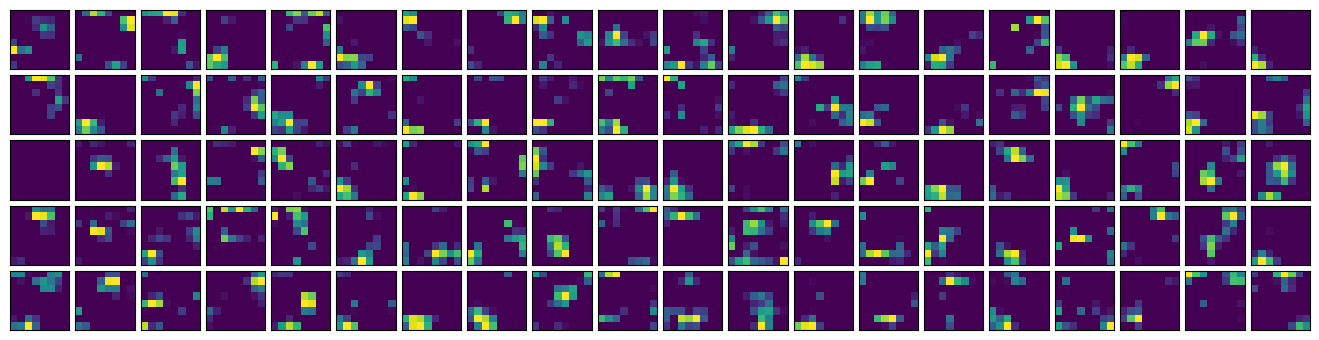

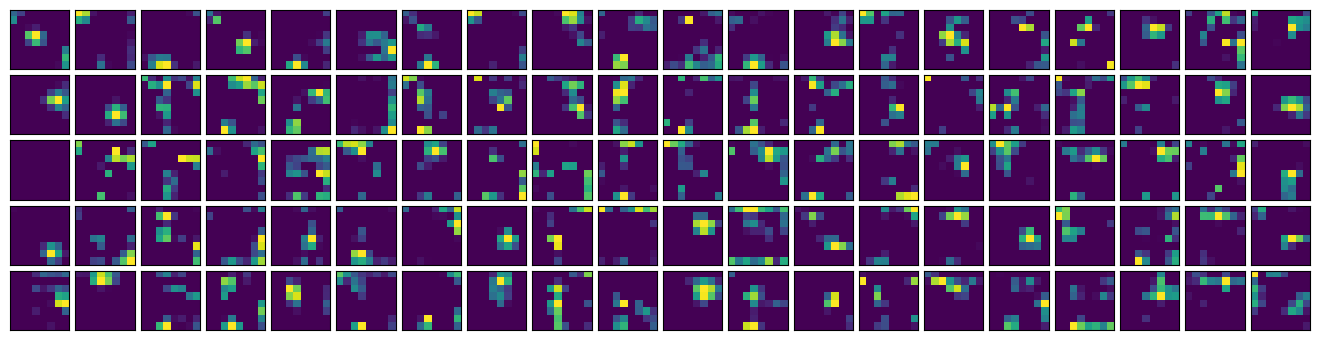

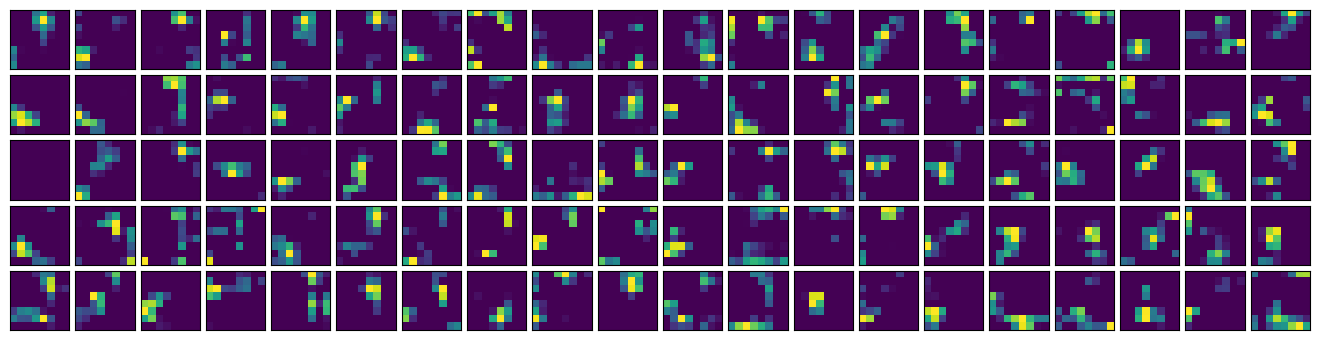

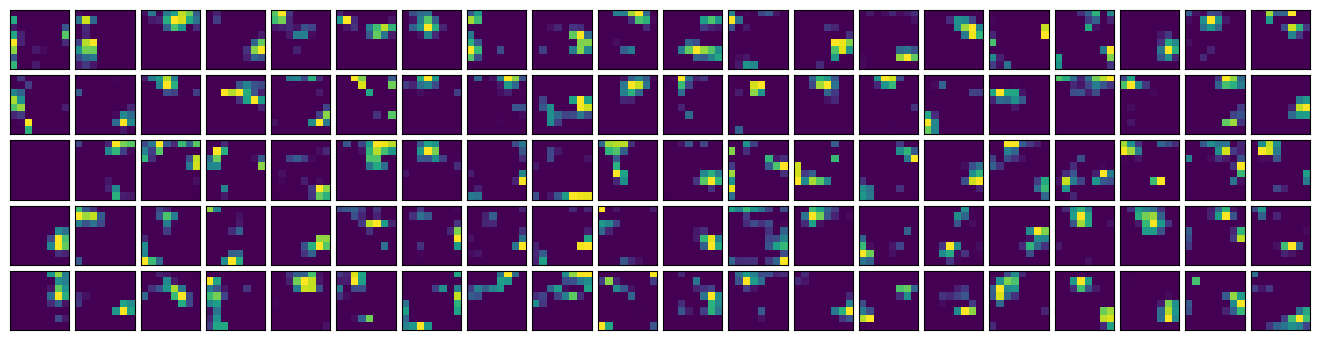

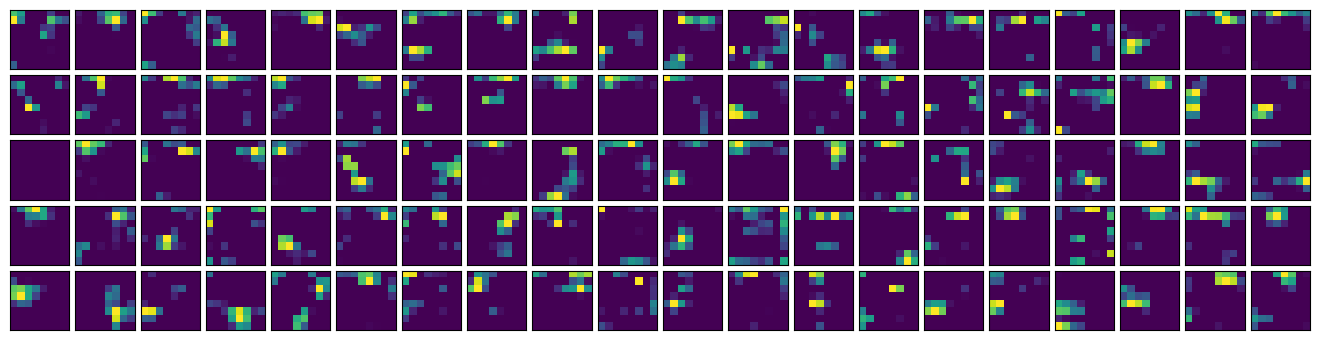

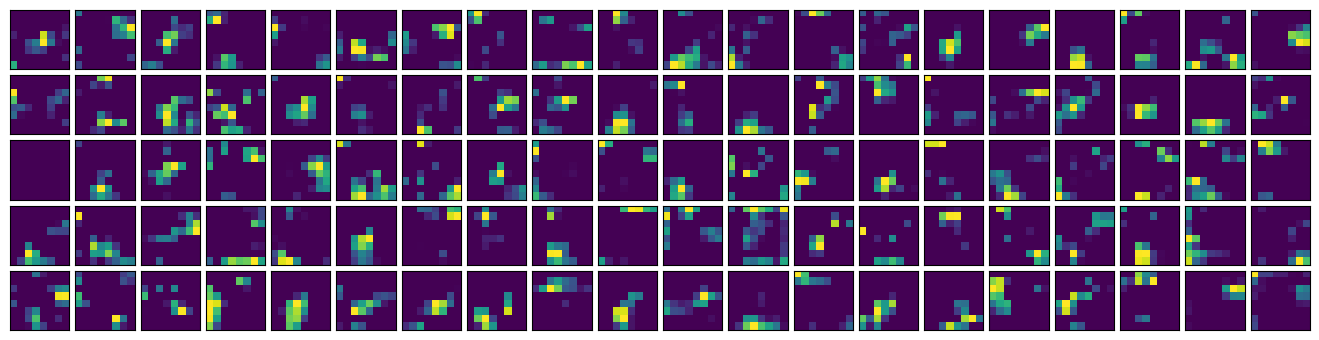

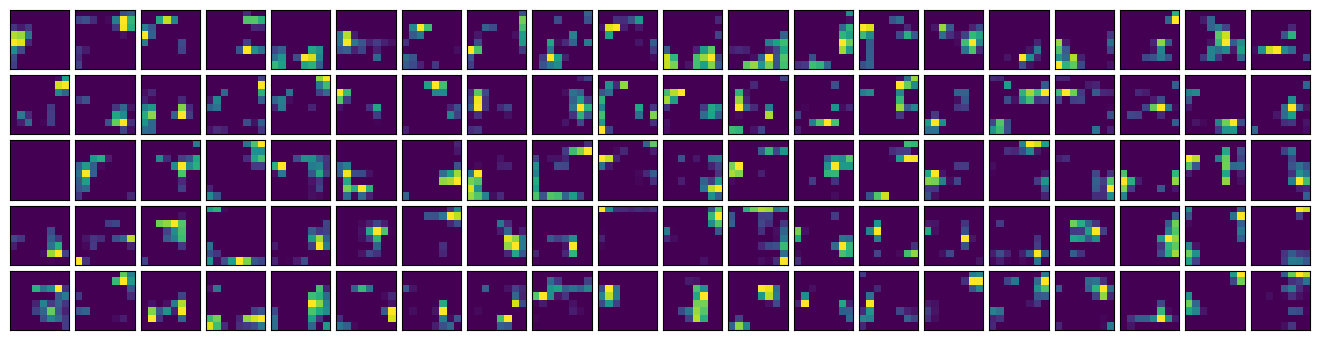

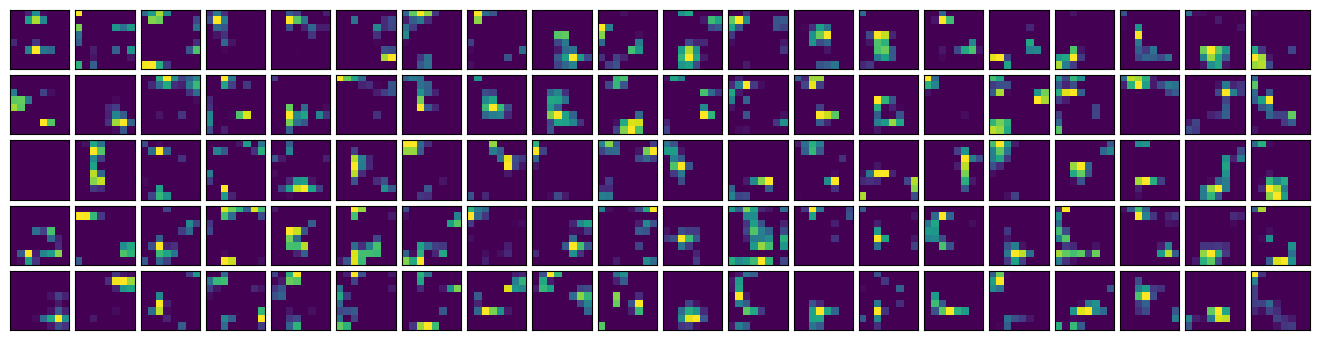

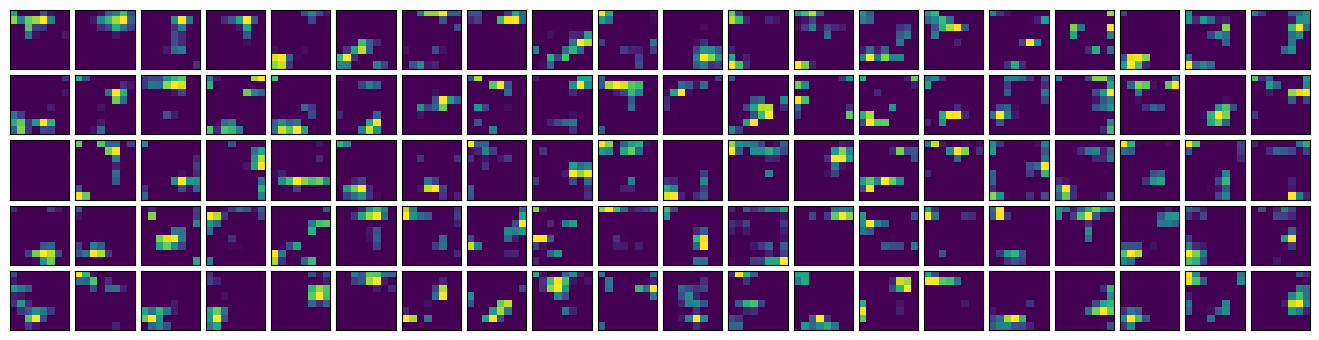

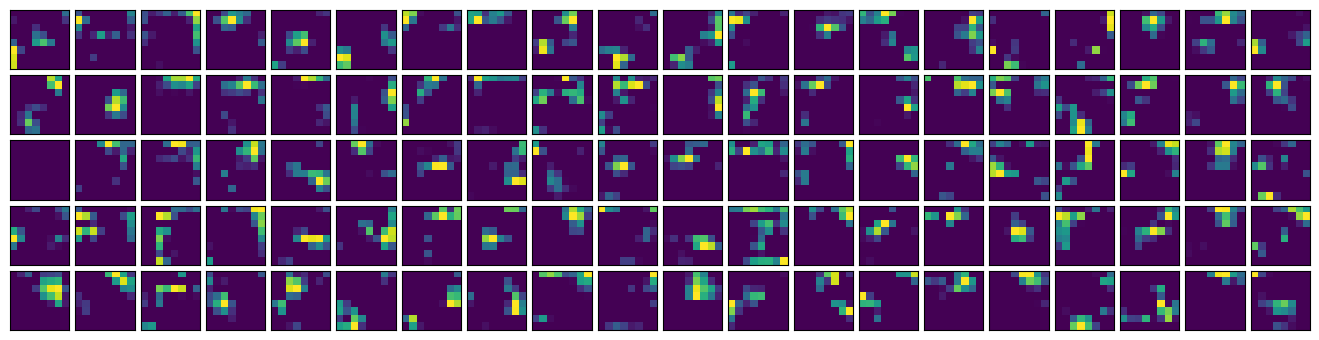

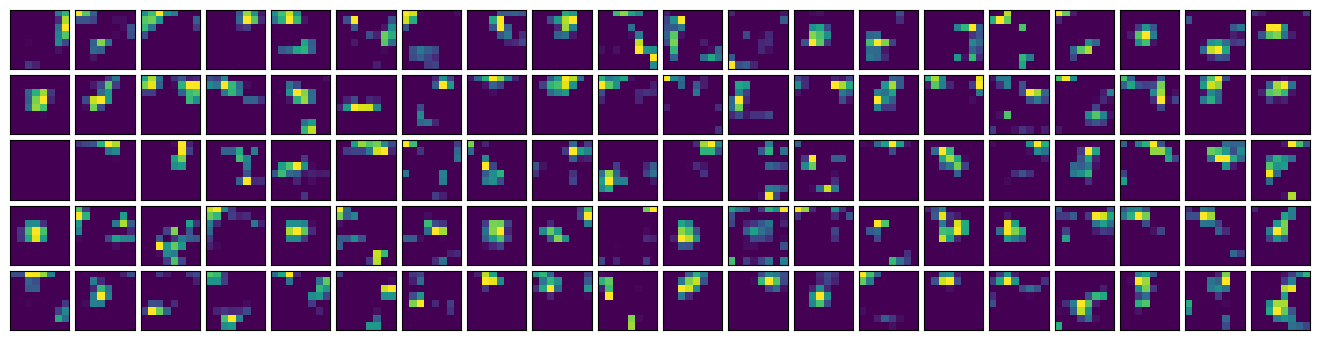

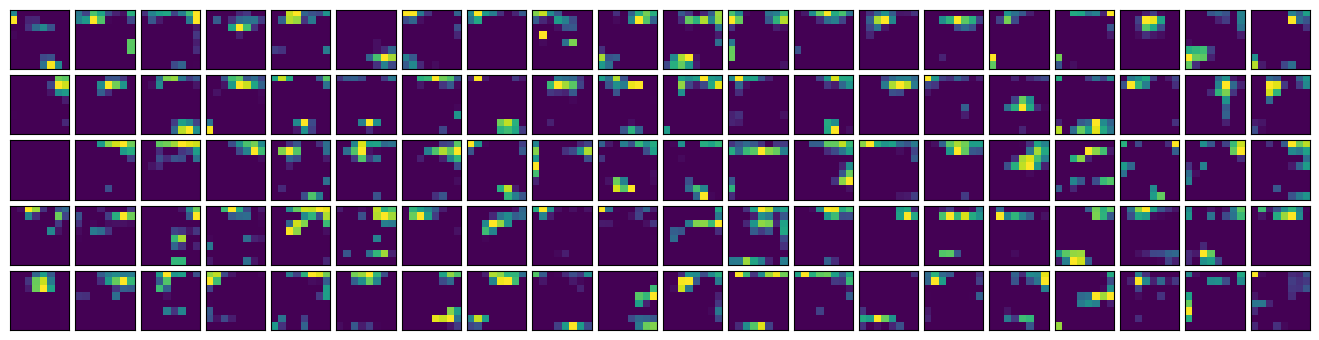

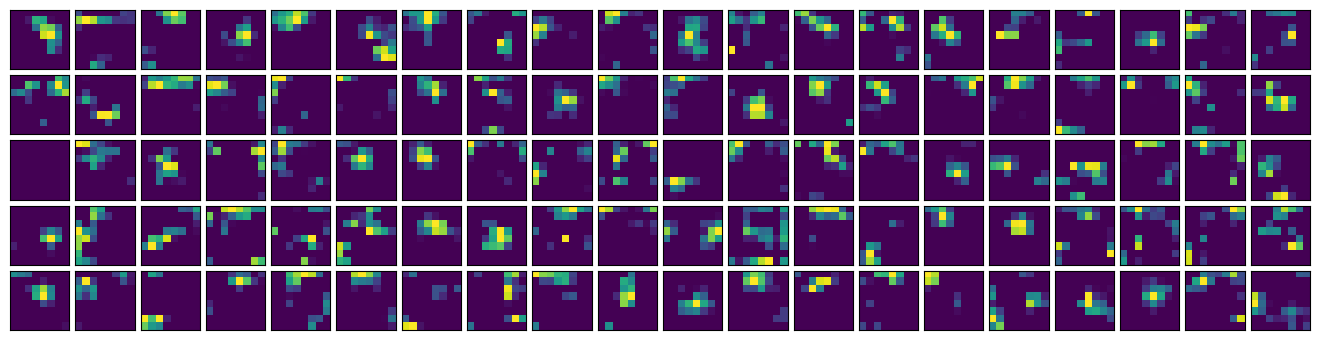

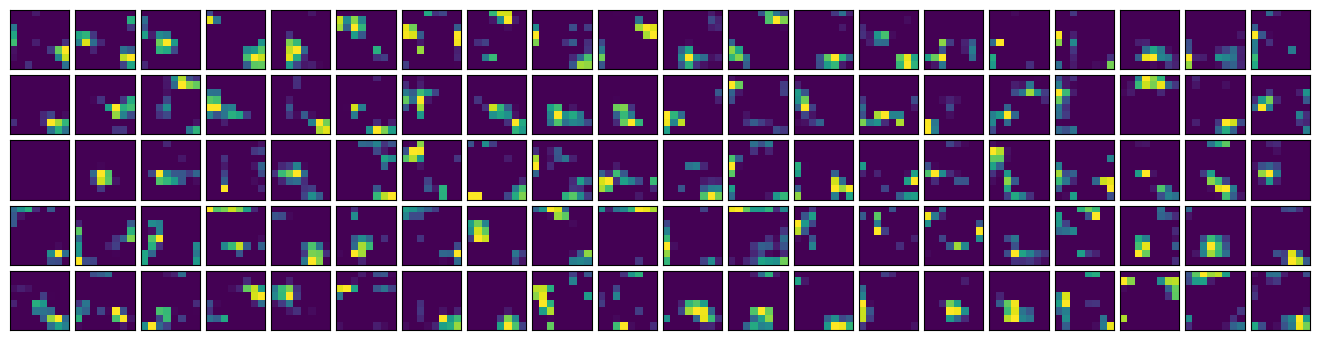

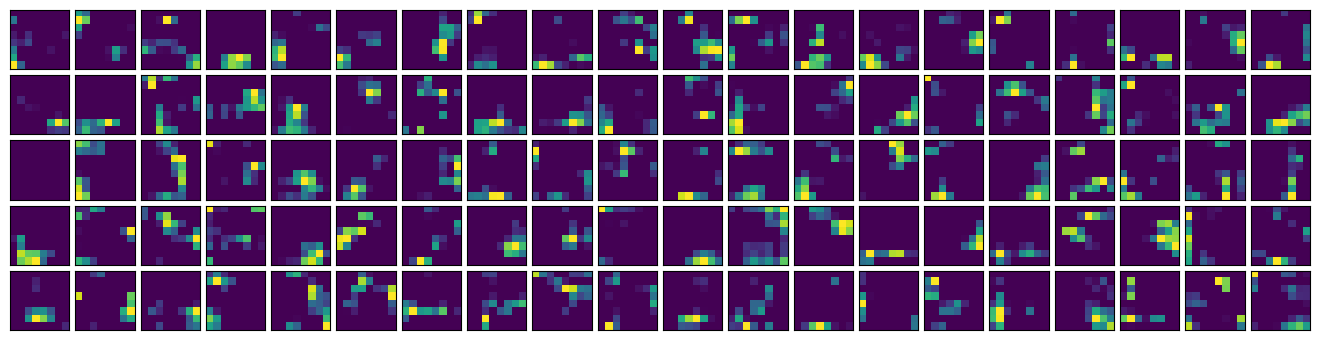

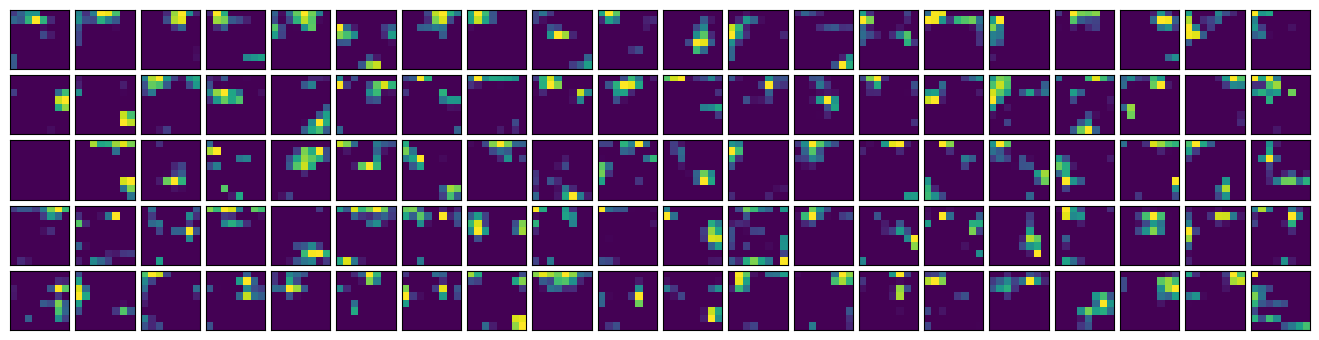

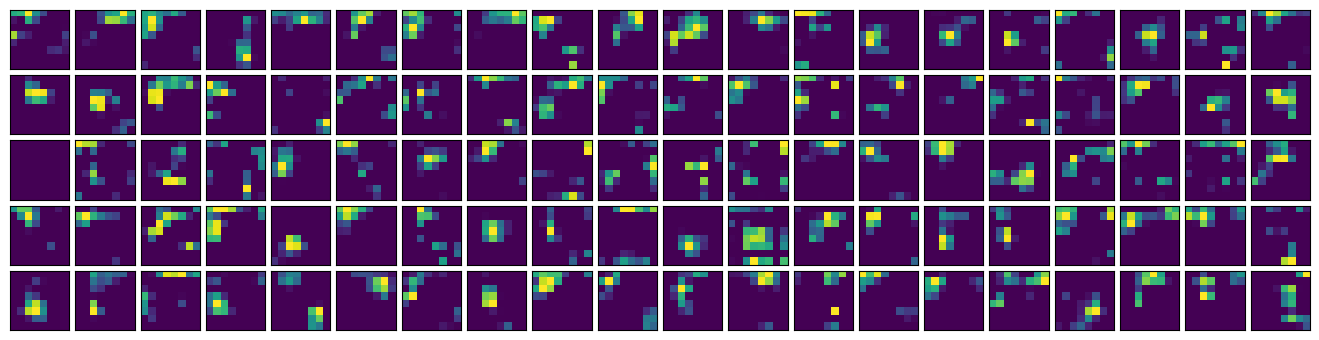

In [9]:
for crop in crops:
    for i in range(crop*3):
        test_loader = GetLoader([], images[crop][i][None], np.zeros([crop*3,1])[None], batch=crop*3, test=True)  
        for train_strategy in ['finetuning']:
            device = torch.device('cuda:2')
            model_name = 'vgg16'
            model = get_model(model_name, device, pretrained=False)
            if crop != 1: model_path = f'./Model/voting{crop}_{model_name}_{train_strategy}.pt'
            if crop == 1:model_path = f'./Model/vgg16_finetuning.pt'

            model.load_state_dict(torch.load(model_path))
            conv_out = LayerActivation(model, 42)

            for data, label in test_loader:
                data, label = data.to(device), label.to(device)
                labels = label.float()
                logits = model(data)

            conv_out.remove()
            maps = conv_out.features

            fig = plt.figure(figsize=(13,4))
            fig.subplots_adjust(left=0, right=1, bottom=0, top=0.8, hspace=0.1, wspace=0.1)

            mean_zero_ratio = 0.0

            for j in range(512):
                if j < 100:
                    ax = fig.add_subplot(5, 20, j+1, xticks=[], yticks=[])
                    ax.imshow(maps[0][j])
                mean_zero_ratio += calculate_zero_ratios(maps[0][j])

            mean_zero_ratio /= 512
            plt.savefig(f'''./GradCam_cropped_images/{crop}/{image_names[crop][i].split('/')[-1].split('.png')[0]}_heatmap_{mean_zero_ratio}.png''')
            print('%.4f' % mean_zero_ratio)